In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2022-11-05 22:18:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.208, 142.250.74.208, 172.217.18.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2022-11-05 22:18:13 (38.4 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [6]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.6690 - accuracy: 0.5658 - val_loss: 0.6145 - val_accuracy: 0.7271 - 4s/epoch - 7ms/step
Epoch 2/30
625/625 - 2s - loss: 0.4638 - accuracy: 0.8107 - val_loss: 0.3973 - val_accuracy: 0.8410 - 2s/epoch - 4ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3232 - accuracy: 0.8717 - val_loss: 0.3845 - val_accuracy: 0.8247 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2681 - accuracy: 0.8963 - val_loss: 0.3823 - val_accuracy: 0.8292 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2325 - accuracy: 0.9105 - val_loss: 0.3597 - val_accuracy: 0.8414 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.2057 - accuracy: 0.9214 - val_loss: 0.3826 - val_accuracy: 0.8359 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1835 - accuracy: 0.9315 - val_loss: 0.3566 - val_accuracy: 0.8532 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1637 - accuracy: 0.9390 - val_loss: 0.3750 - val_accuracy: 0.8499 - 2s/epoch - 4ms/step
Epoch 9/30
625/625 - 2s 

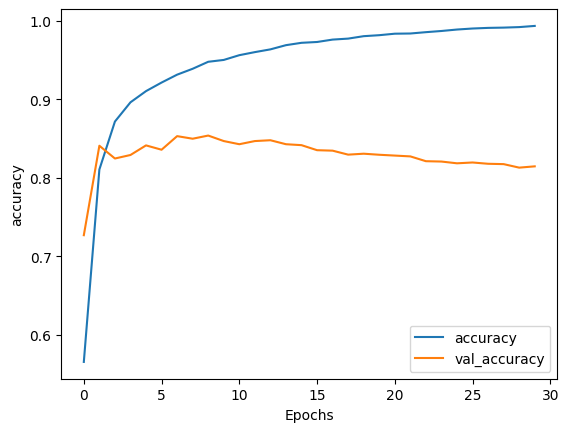

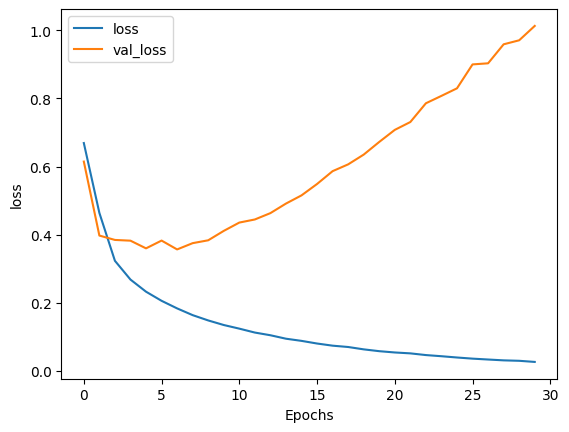

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [17]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [21]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded)*100)

1/1 [==============================] - 0s 45ms/step
[[9.640388e+01]
 [2.238182e-03]]


In [47]:
def isSarcastic(prediction, sentence):
    if len(prediction) > 1:
        for i, v in enumerate(prediction):
            if v > 0.5:
                print("\n", sentence[i], "-> is Sarcastic:", str(v[0]*100) + "%")
            else:
                print("\n", sentence[i], "-> is Serious:", str(v[0]*100) + "%")
    else:
        if prediction > 0.5:
            print("\n", sentence, "-> is Sarcastic:", prediction)
        else:
            print("\n", sentence, "-> is Serious:", prediction)

In [48]:
       
sentence = [
    "granny starting to fear spiders in the garden might be real", 
    "game of thrones season finale showing this sunday night"
]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
isSarcastic(model.predict(padded), sentence)

1/1 [==============================] - 0s 46ms/step

 granny starting to fear spiders in the garden might be real -> is Sarcastic: 96.40387892723083%

 game of thrones season finale showing this sunday night -> is Serious: 0.0022381818780559115%
